This notebook demonstrates the replication analysis for 24 stroke patients with motor symptoms (moderate symptoms: 19, severe symptoms: 5) compared to a controls group comprising 30 stroke patients without motor symptoms.

As in the main analysis, we here find significantly increased dwell times in case of moderate symptoms.
Furthermore, we substantiate a reduced level of system segregation in case of moderate symptoms compared to controls and patients with severe symptoms. Lastly, severely affected patients have a significantly increased level of system segregation compared to both other groups.
Altogether, we therefore replicate main findings of the original study.

Please note that State 1 in this notebook represents the weakly connected State 2 of the main analysis and State 2 the densely connected State 1 (this change is due to the altered ordering of states in the k-means clustering step. Please note that the order of states was altered in supplementary figure 4 to match the order of states in the main analysis)

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import glob
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from pingouin import pairwise_corr
import statsmodels.stats.multicomp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.formula.api as sm
import statsmodels.api as sm
from matplotlib import cm
import math

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

from sklearn.metrics import roc_curve, auc
from scipy import interp
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [2]:
def calc_num_components(a):
    num_pairs = len(a)
    num_components = int(np.ceil(np.sqrt(2 * num_pairs - 1)))
    if num_components * (num_components - 1) == 2 * num_pairs:
        return num_components
    else:
        return 0


def return_dfnc_from_vector(a):
    '''This Function returns a dfnc matrix given a vector
        a : the vector of correlation pairs
    '''
    n = calc_num_components(a)
    out = np.zeros((n, n))

    if not n:
        return out
    
    l_indices = np.tril_indices(n, -1)
    u_indices = np.triu_indices(n, 1)

    out[u_indices] = a
    out[l_indices] = out.T[l_indices]
    
    return out

In [3]:
n_subjects = 54
n_windows = 159
n_corr = 78

In [4]:
Stroke_final = pd.read_csv("/Users/anna/Documents/AR_Stroke_new/Behavior/AR_Behavior_revision.csv", index_col=0)

In [5]:
# Load behavioural data
Stroke_final = pd.read_csv("/Users/anna/Documents/AR_Stroke_new/Behavior/AR_Behavior_revision.csv", index_col=0)

In [6]:
# MI Upper limb
mild = Stroke_final[Stroke_final["MI"]>32].index # these patients presented without any motor deficits (MI=33) and represent the control group
severe = Stroke_final[Stroke_final["MI"]<22].index
moderate = Stroke_final[Stroke_final["MI"]<33]
moderate = moderate[moderate["MI"]>21].index

In [7]:
subgroups = np.zeros(54)
subgroups[moderate] = 1
subgroups[severe] = 2

In [8]:
subject_names = glob.glob('/Users/anna/Documents/AR_Stroke_new/Data/DFNC_SM_0509/WithSM_dfnc_sub*',)
subject_names = sorted(subject_names)

In [9]:
# loading individual fncs
dfnc = np.zeros((n_subjects,n_windows,n_corr))
for n in range(0,n_subjects,1):
    dfnc[n] = loadmat(subject_names[n][-40:])['FNCdyn']

In [10]:
# loading state information 
x = loadmat('states_stroke.mat')["a"]
for n in range(0,np.shape(x)[0],1):
    if n==0:
        states = pd.DataFrame(x[n][0])
    else:
        states[n] = pd.DataFrame(x[n][0])
states = states.transpose()

In [11]:
fraction = loadmat('fraction_time.mat')["frac"]
fraction = pd.DataFrame(fraction)
fraction.columns = ["State_1", "State_2", "State_3"]

In [12]:
# Comparing Fraction times for patients without motor symptoms (controls) and moderate symptoms: No significant differences
n_dfnc = ["State_1", "State_2", "State_3",]
no = [0,1,2]
p_all = np.zeros(3)
print("Fraction time")
for n, p in zip(n_dfnc, no):
    rvs2= fraction[n].loc[mild]
    rvs1 = fraction[n].loc[moderate]
    p_all[p] = stats.ttest_ind(rvs1,rvs2)[1] 
    print("%s" % n)
    print("No deficit: %f" %(rvs2.mean()))
    print("Moderate Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Fraction time
State_1
No deficit: 0.434172
Moderate Deficit: 0.525654
0.305045
State_2
No deficit: 0.222851
Moderate Deficit: 0.224429
0.983896
State_3
No deficit: 0.342977
Moderate Deficit: 0.249917
0.195401


In [13]:
# Comparing Fraction times for patients without motor symptoms (controls) and severe symptoms: No significant differences
n_dfnc = ["State_1", "State_2", "State_3"]
no = [0,1,2]
p_all = np.zeros(3)
print("Fraction time")
for n, p in zip(n_dfnc, no):
    rvs2 = fraction[n].loc[mild]
    rvs1 = fraction[n].loc[severe]
    p_all[p] = stats.ttest_ind(rvs1,rvs2)[1] 
    print("%s" % n)
    print("No deficit: %f" %(rvs2.mean()))
    print("Severe Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Fraction time
State_1
No deficit: 0.434172
Severe Deficit: 0.527044
0.508866
State_2
No deficit: 0.222851
Severe Deficit: 0.293082
0.545713
State_3
No deficit: 0.342977
Severe Deficit: 0.179874
0.152576


In [14]:
# Comparing Fraction times for patients with moderate and severesymptoms: No significant differences

n_dfnc = ["State_1", "State_2", "State_3"]
no = [0,1,2]
p_all = np.zeros(3)
print("Fraction time")
for n, p in zip(n_dfnc, no):
    rvs2 = fraction[n].loc[moderate]
    rvs1 = fraction[n].loc[severe]
    p_all[p] = stats.ttest_ind(rvs1,rvs2)[1] 
    print("%s" % n)
    print("Moderate deficit: %f" %(rvs2.mean()))
    print("Severe Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Fraction time
State_1
Moderate deficit: 0.525654
Severe Deficit: 0.527044
0.994025
State_2
Moderate deficit: 0.224429
Severe Deficit: 0.293082
0.688374
State_3
Moderate deficit: 0.249917
Severe Deficit: 0.179874
0.604990


/Users/anna/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

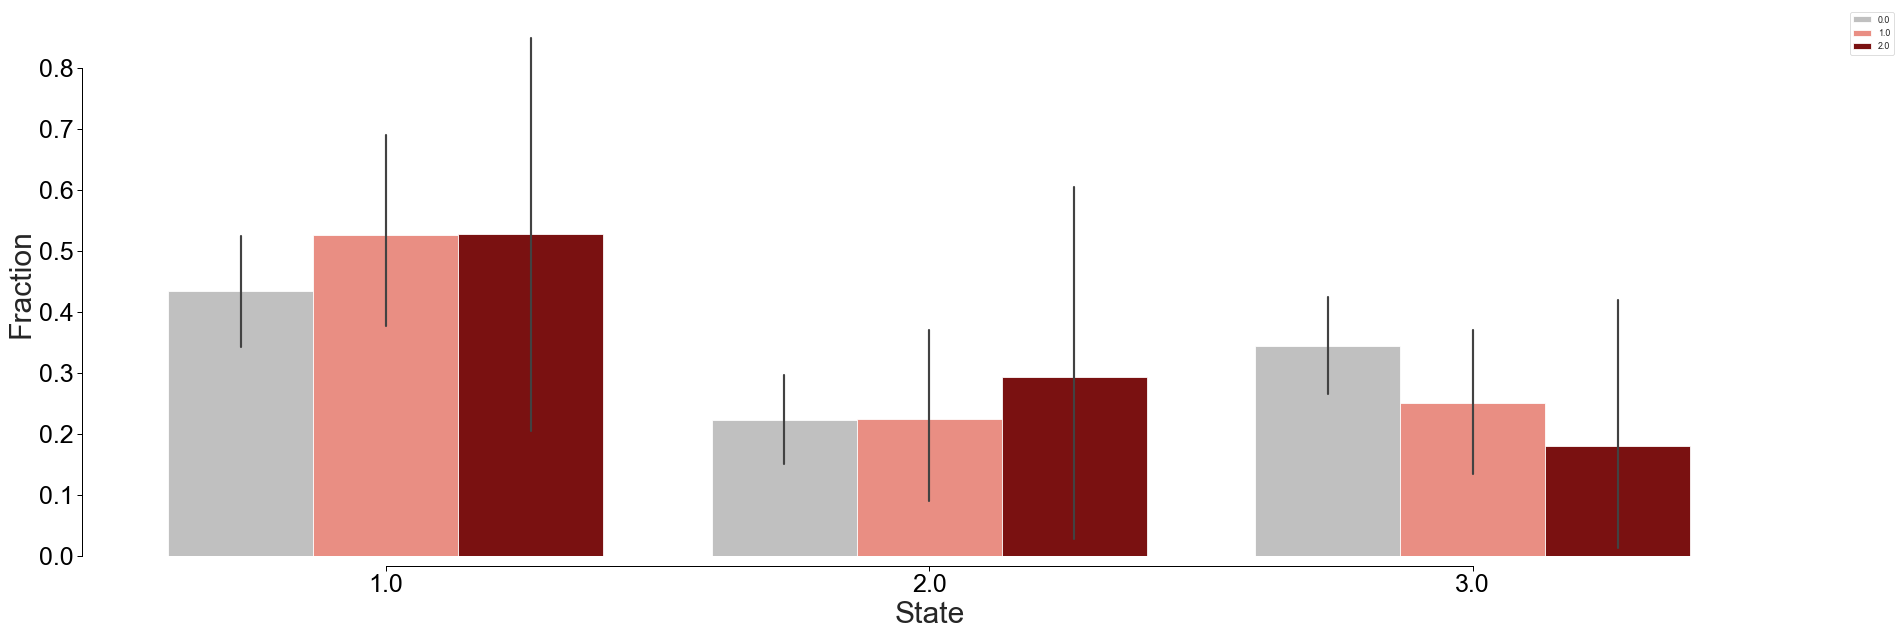

In [15]:
fraction_fig = pd.concat([fraction["State_1"], fraction["State_2"], fraction["State_3"]], axis=0)
fraction_fig = pd.DataFrame(fraction_fig)
fraction_fig.index = range(0,n_subjects*3)
fraction_fig = fraction_fig.rename(index=str, columns={0: "Fraction"})
fraction_fig["State"] = np.concatenate([np.ones(n_subjects), np.full(n_subjects,2),np.full(n_subjects,3)])
fraction_fig["Patient_status"] = np.concatenate([subgroups, subgroups, subgroups])
plt.figure(figsize=(30, 10))
#sns.set(style="ticks", palette="pastel")   
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

sns.set_context("paper", rc={"font.size":30,"axes.titlesize":30,"axes.labelsize":30}) 

#sns.stripplot(x="State", y="Fraction", hue="Patient_status",
#data=fraction_fig, jitter=True,
#palette=["skyblue", "dodgerblue", "blue"], split=True,linewidth=1,edgecolor='white')
#palette=["floralwhite", "floralwhite", "floralwhite"], split=True,linewidth=1,size=8,edgecolor='grey')

# Draw a nested boxplot to show bills by day and time
sns.barplot(x="State", y="Fraction",
            hue="Patient_status",palette=["silver", "salmon", "darkred"],
            #hue="Patient_status",kind="bar",  palette=["silver", "salmon", "darkred"],
            data=fraction_fig)



sns.despine(offset=10, trim=True)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot()

In [16]:
dwell = loadmat('dwell_time.mat')["dwell"]
dwell = pd.DataFrame(dwell)
dwell.columns = ["State_1", "State_2", "State_3"]

In [17]:
# Comparing Fraction times for patients without motor symptoms (controls) and moderate symptoms: State 1, 
# the weakly connected State 2 of the original dataset,
# shows a significantly increased dwell time in case of moderate symptoms 
no = [0,1,2]
p_all = np.zeros(3)
print("Dwell time per state")
for n, p in zip(n_dfnc, no):
    rvs1 = dwell[n].loc[mild]
    rvs2 = dwell[n].loc[moderate]
    p_all[p] = stats.ttest_ind(rvs1,rvs2)[1]
    print("%s" % n)
    print("Moderate deficit: %f" %(rvs2.mean()))
    print("No Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Dwell time per state
State_1
Moderate deficit: 46.607018
No Deficit: 23.470556
0.029015
State_2
Moderate deficit: 18.416667
No Deficit: 12.216667
0.392665
State_3
Moderate deficit: 16.187719
No Deficit: 17.843889
0.668600


In [19]:
# Comparing Fraction times for patients without motor symptoms (controls) and severe symptoms: No significant differences
n_dfnc = ["State_1", "State_2", "State_3",]
no = [0,1,2]
p_all = np.zeros(3)
print("Dwell time per state")
for n, p in zip(n_dfnc, no):
    rvs1 = dwell[n].loc[mild]
    rvs2 = dwell[n].loc[severe]
    p_all[p] = stats.ttest_ind(rvs1,rvs2)[1]
    print("%s" % n)
    print("Severe deficit: %f" %(rvs2.mean()))
    print("No Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Dwell time per state
State_1
Severe deficit: 48.300000
No Deficit: 23.470556
0.061623
State_2
Severe deficit: 17.800000
No Deficit: 12.216667
0.277886
State_3
Severe deficit: 8.200000
No Deficit: 17.843889
0.052664


In [20]:
# Comparing Fraction times for patients with moderate and severe symptoms: No significant differences
n_dfnc = ["State_1", "State_2", "State_3"]
no = [0,1,2,3]
p_all = np.zeros(4)
print("Dwell time per state")
for n, p in zip(n_dfnc, no):
    rvs1 = dwell[n].loc[severe]
    rvs2 = dwell[n].loc[moderate]
    p_all[p] = stats.ttest_ind(rvs1,rvs2)[1]
    print("%s" % n)
    print("Moderate deficit: %f" %(rvs2.mean()))
    print("Severe Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Dwell time per state
State_1
Moderate deficit: 46.607018
Severe Deficit: 48.300000
0.951662
State_2
Moderate deficit: 18.416667
Severe Deficit: 17.800000
0.972435
State_3
Moderate deficit: 16.187719
Severe Deficit: 8.200000
0.334026


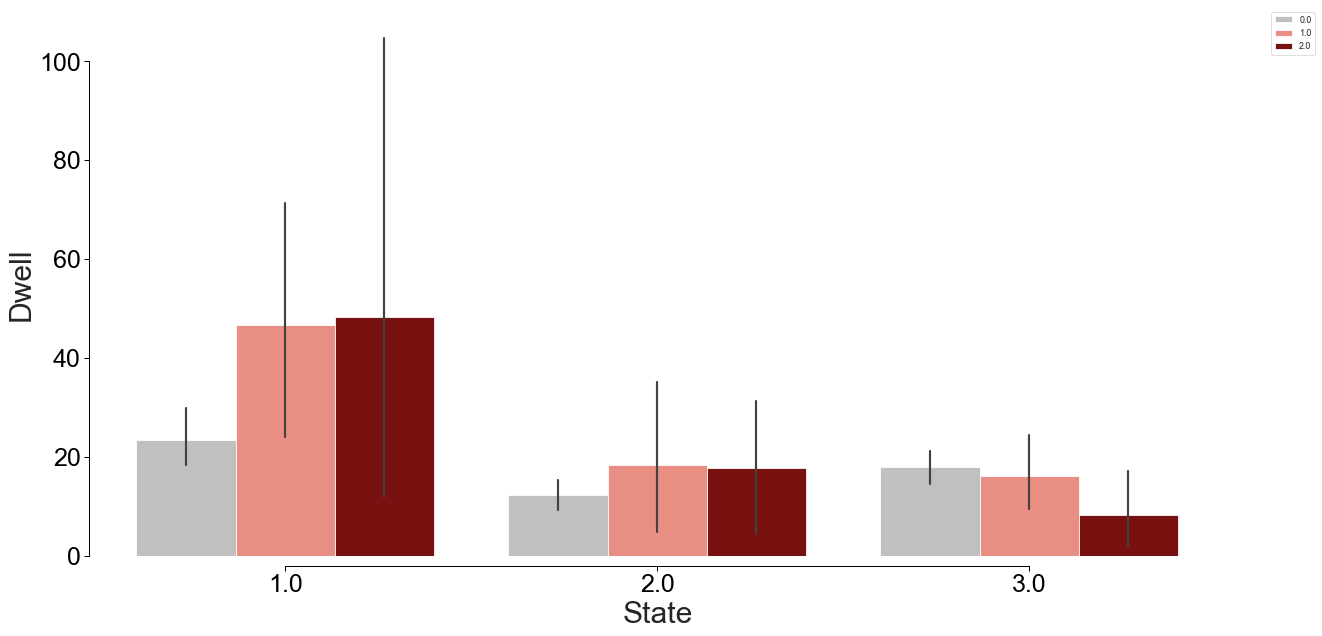

In [22]:
fraction_fig = pd.concat([dwell["State_1"], dwell["State_2"], dwell["State_3"]], axis=0)
fraction_fig = pd.DataFrame(fraction_fig)
fraction_fig.index = range(0,n_subjects*3)
fraction_fig = fraction_fig.rename(index=str, columns={0: "Dwell"})
fraction_fig["State"] = np.concatenate([np.ones(n_subjects), np.full(n_subjects,2),np.full(n_subjects,3)])
fraction_fig["Patient_status"] = np.concatenate([subgroups, subgroups, subgroups])

plt.figure(figsize=(20, 10))
#sns.set(style="ticks", palette="pastel")   
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

sns.set_context("paper", rc={"font.size":30,"axes.titlesize":30,"axes.labelsize":30}) 

#sns.stripplot(x="State", y="Dwell", hue="Patient_status",
#data=fraction_fig, jitter=True,
#palette=["skyblue", "dodgerblue", "blue"], split=True,linewidth=1,edgecolor='white')
#palette=["floralwhite", "floralwhite", "floralwhite"], split=True,linewidth=1,size=8,edgecolor='grey')

# Draw a nested boxplot to show bills by day and time
sns.barplot(x="State", y="Dwell",
            #hue="Patient_status",palette=["mistyrose", "salmon", "darkred"],
            hue="Patient_status",palette=["silver", "salmon", "darkred"],
            data=fraction_fig)
sns.despine(offset=10, trim=True)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [23]:
transition = loadmat('transition.mat')["transition"]

In [24]:
# No significant differences for transition likelihoods between the groups
trans_p = []
for no_1 in range(0,3,1):
    for no_2 in range(0,3,1):
        trans_c = []
        trans_pb = []
        trans_pw = []
        for n in mild:
                trans_c.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        for n in moderate:
                trans_pb.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        for n in severe:
                trans_pw.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        print(no_1)
        print(no_2)
        trans_p.append(stats.f_oneway(np.array(trans_c), np.array(trans_pb),np.array(trans_pw))[1])
        print("Transition: %f" %stats.f_oneway(np.array(trans_c), np.array(trans_pb),np.array(trans_pw))[1])
              
              

0
0
Transition: 0.126363
0
1
Transition: 0.386342
0
2
Transition: 0.390054
1
0
Transition: 0.621572
1
1
Transition: 0.130173
1
2
Transition: 0.053117
2
0
Transition: 0.928609
2
1
Transition: 0.511440
2
2
Transition: 0.668574


In [25]:
# Creating state averages (MEDIAN) per subject
dfnc_1_med = pd.DataFrame(np.zeros((n_subjects, n_corr)))
dfnc_2_med = pd.DataFrame(np.zeros((n_subjects, n_corr)))
dfnc_3_med = pd.DataFrame(np.zeros((n_subjects, n_corr)))

for n in range(0,n_subjects,1):
        dfnc_1_med.loc[n] = np.array(pd.DataFrame(dfnc[n][states.loc[n]==1]).median(axis=0))
        dfnc_1_med = pd.DataFrame(dfnc_1_med)
        dfnc_2_med.loc[n] = np.array(pd.DataFrame(dfnc[n][states.loc[n]==2]).median(axis=0))
        dfnc_2_med = pd.DataFrame(dfnc_2_med)
        dfnc_3_med.loc[n] = np.array(pd.DataFrame(dfnc[n][states.loc[n]==3]).median(axis=0))
        dfnc_3_med = pd.DataFrame(dfnc_3_med)

In [26]:
# compare between subjects
a = np.ravel(dfnc)
a = np.reshape(a,(8586,78))

In [27]:
seg_11_all = []
seg_1_all = []

for n in range(8586):
    dfnc_1_group_med = pd.DataFrame(return_dfnc_from_vector(a[n]))

    dfnc_1_group_med_SM = dfnc_1_group_med.loc[0:7,0:7]*(dfnc_1_group_med.loc[0:7,0:7]>0)
    dfnc_1_group_med_SM = np.array(dfnc_1_group_med_SM)[np.triu_indices(8,1)]
    dfnc_1_group_med_SC = dfnc_1_group_med.loc[8:10,8:10]*(dfnc_1_group_med.loc[8:10,8:10]>0)
    dfnc_1_group_med_SC = np.array(dfnc_1_group_med_SC)[np.triu_indices(3,1)]
    dfnc_1_group_med_CB = dfnc_1_group_med.loc[11:12,11:12]*(dfnc_1_group_med.loc[11:12,11:12]>0)
    dfnc_1_group_med_CB = np.array(dfnc_1_group_med_CB)[np.triu_indices(2,1)]
    within_1 = np.concatenate([dfnc_1_group_med_SM, dfnc_1_group_med_SC, dfnc_1_group_med_CB])
    within_1 = np.sum(within_1)/(len(dfnc_1_group_med_SM) +len(dfnc_1_group_med_SC)+len(dfnc_1_group_med_CB)) 
    dfnc_1_group_med_SM_SC_CB = np.array(dfnc_1_group_med.loc[8:,0:7]*(dfnc_1_group_med.loc[8:,0:7]>0))
    dfnc_1_group_med_SC_CB = np.array(dfnc_1_group_med.loc[8:10,11:]*(dfnc_1_group_med.loc[8:10,11:]>0))
    between_1 = np.concatenate([np.ravel(dfnc_1_group_med_SM_SC_CB),np.ravel(dfnc_1_group_med_SC_CB)])
    between_1 = np.sum(between_1)/(len(np.ravel(dfnc_1_group_med_SM_SC_CB)) +len(np.ravel(dfnc_1_group_med_SC_CB))) 
    seg_11 = (within_1 - between_1) / within_1
    seg_11_all.append(seg_11)
 
    dfnc_1_group_med_SM = dfnc_1_group_med.loc[0:7,0:7]
    dfnc_1_group_med_SM = np.array(dfnc_1_group_med_SM)[np.triu_indices(8,1)]
    dfnc_1_group_med_SC = dfnc_1_group_med.loc[8:10,8:10]
    dfnc_1_group_med_SC = np.array(dfnc_1_group_med_SC)[np.triu_indices(3,1)]
    dfnc_1_group_med_CB = dfnc_1_group_med.loc[11:12,11:12]
    dfnc_1_group_med_CB = np.array(dfnc_1_group_med_CB)[np.triu_indices(2,1)]
    within_1 = np.concatenate([dfnc_1_group_med_SM, dfnc_1_group_med_SC, dfnc_1_group_med_CB])
    within_1 = np.sum(within_1)/(len(dfnc_1_group_med_SM) +len(dfnc_1_group_med_SC)+len(dfnc_1_group_med_CB)) 
    dfnc_1_group_med_SM_SC_CB = np.array(dfnc_1_group_med.loc[8:,0:7])
    dfnc_1_group_med_SC_CB = np.array(dfnc_1_group_med.loc[8:10,11:])
    between_1 = np.concatenate([np.ravel(dfnc_1_group_med_SM_SC_CB),np.ravel(dfnc_1_group_med_SC_CB)])
    between_1 = np.sum(between_1)/(len(np.ravel(dfnc_1_group_med_SM_SC_CB)) +len(np.ravel(dfnc_1_group_med_SC_CB))) 
    seg_1 = (within_1 - between_1) / within_1
    seg_1_all.append(seg_1)

In [28]:
seg_11_control = []
for sub in mild:
    sub_raveled = sub*159
    for sub_rav in range(sub_raveled, (sub_raveled+159)):
        seg_11_control.append(pd.DataFrame(seg_11_all).loc[sub_rav][0])

In [29]:
# System segregation for controls
pd.DataFrame(seg_11_control).mean()

0    0.763816
dtype: float64

In [30]:
seg_11_better = []
for sub in moderate:
    sub_raveled = sub*159
    for sub_rav in range(sub_raveled, (sub_raveled+159)):
        seg_11_better.append(pd.DataFrame(seg_11_all).loc[sub_rav][0])

In [31]:
# System segregation for moderately affected patients
pd.DataFrame(seg_11_better).mean()

0    0.739656
dtype: float64

In [32]:
seg_11_worse = []
for sub in severe:
    sub_raveled = sub*159
    for sub_rav in range(sub_raveled, (sub_raveled+159)):
        seg_11_worse.append(pd.DataFrame(seg_11_all).loc[sub_rav][0])

In [33]:
# System segregation for severely affected patients
pd.DataFrame(seg_11_worse).mean()

0    0.807129
dtype: float64

In [34]:
# One-Way ANOVA testing between-group differences in system segregation: Indicating a significant effect
stats.f_oneway(np.array(seg_11_control), np.array(seg_11_better), np.array(seg_11_worse))

F_onewayResult(statistic=47.80472988068337, pvalue=2.2565884067951002e-21)

In [35]:
# Post-hoc t-test testing differences between controls and moderately affected patients in system segregation: Indicating a significant effect
stats.ttest_ind(np.array(seg_11_control),np.array(seg_11_better))

Ttest_indResult(statistic=5.647911980586883, pvalue=1.68124032369405e-08)

In [36]:
# Post-hoc t-test testing differences between controls and severely affected patients in system segregation: Indicating a significant effect
stats.ttest_ind(np.array(seg_11_control),np.array(seg_11_worse))

Ttest_indResult(statistic=-6.9273246778043225, pvalue=4.773813503864772e-12)

In [37]:
# Post-hoc t-test testing differences between severely and moderately affected patients in system segregation: Indicating a significant effect
stats.ttest_ind(np.array(seg_11_better),np.array(seg_11_worse))

Ttest_indResult(statistic=-8.788752661587644, pvalue=2.2467298056322077e-18)

In [38]:
import statsmodels.stats.multicomp
statsmodels.stats.multitest.multipletests([1.68124032369405e-08,4.773813503864772e-12, 2.2467298056322077e-18], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)


(array([ True,  True,  True]),
 array([1.68124032e-08, 7.16072026e-12, 6.74018942e-18]),
 0.016952427508441503,
 0.016666666666666666)